In [1]:
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import numpy as np

# from matplotlib.mlab import bivariate_normal

import cartopy.crs as ccrs
import xarray as xr
import pandas as pd

import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from matplotlib.ticker import EngFormatter, StrMethodFormatter

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from datetime import date

from tqdm import tqdm
import os 

In [2]:
Years = ["2000","2001","2002","2003","2004","2005","2006","2007","2008","2009"]
# Years = ["2009"]
Nyears = np.arange(2000,2010,1)

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
Nmonths = np.arange(1,13,1)
    
Days = []
for iday in range(1,29,3):
    Days.append(str(iday).zfill(2))
Ndays = np.arange(1,29,3)
    
print(Years, Nyears)
print(Months, Nmonths)
print(Days, Ndays)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009'] [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009]
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'] [ 1  2  3  4  5  6  7  8  9 10 11 12]
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28'] [ 1  4  7 10 13 16 19 22 25 28]


In [3]:
Pressure = [100, 75, 65, 55, 40, 30] # hPa
Height   = [16,  17.92, 18.87, 20, 22.1, 24] # km

LATs = np.arange(-30,31,3)


In [4]:
Nx = 24
Ny = 21
Nz = 6
N_parcel = Nx*Ny*Nz
# if Nx*Ny*Nz!=N_parcel: print('ERROR: parcel number is wrong!')
    
N_year  = len(Years)
N_month = len(Months)
N_day   = len(Days)


# tropical exiting locations
LON1 = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
LAT1 = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
LEV1 = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

lifetime1   = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime1_N = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime1_S = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

LON1_exit = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
LAT1_exit = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
LEV1_exit = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
print(LON1_exit.shape)


(6, 21, 24, 10, 12, 10)


In [5]:
Levs = np.arange(2,101,2)
Levs_edge = np.arange(1,102,2)
def find_iLev(Pressure):
    iLev = -1
    for ip in range(len(Levs)):
        if Pressure>Levs_edge[ip] and Pressure<=Levs_edge[ip+1]:
            iLev = ip
            break
    return iLev

In [6]:
Levs, Levs_edge

(array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
         28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
         54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
         80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100]),
 array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
         27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
         53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
         79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101]))

In [7]:
# for tropical exiting locations

N_days = 20*366
N_Levs = len(Levs)
Flux = np.zeros((N_days, N_Levs))

directory1 = '/n/home12/hongwei/Paper_3_QBO/Exiting_Pressure_data/'
filename1 = "Exiting_Press_"+Years[0]+Months[0]+Days[0]+".txt"
print(directory1+filename1)

for i_year in range(N_year):
    for i_month in tqdm(range(N_month)):
        for i_day in range(N_day):
            filename1 = "Exiting_Press_"+Years[i_year]+Months[i_month]+Days[i_day]+".txt"
            File1 = open(directory1+filename1, 'r')
        
            Lines1 = File1.readlines()

            # Strips the newline character
            data   = []
            data_N = []
            data_S = []
            Longitude = []
            Latitude  = []
            Press     = []
            Longitude_final = []
            Latitude_final  = []
            Press_final = []
            for line1 in Lines1:
                a1 = line1.split(',')
                # tropical lifetime
                data.append(float(a1[0]))
                data_N.append(float(a1[1]))
                data_S.append(float(a1[2]))
                # injection location
                Longitude.append(float(a1[3]))
                Latitude.append(float(a1[4]))
                Press.append(float(a1[5]))
                # tropical exiting locations
                Longitude_final.append(float(a1[6]))
                Latitude_final.append(float(a1[7]))
                Press_final.append(float(a1[8]))
            
    
            i = 0
            for ix in range(Nx):
                for iy in range(Ny):
                    for iz in range(Nz):
                        
                        # tropical lifetime
                        lifetime1[iz,iy,ix,i_day,i_month,i_year]   = data[i]
                        lifetime1_N[iz,iy,ix,i_day,i_month,i_year] = data_N[i]
                        lifetime1_S[iz,iy,ix,i_day,i_month,i_year] = data_S[i]
                        
                        # injection location
                        LON1[iz,iy,ix,i_day,i_month,i_year] = Longitude[i]
                        LAT1[iz,iy,ix,i_day,i_month,i_year] = Latitude[i]
                        LEV1[iz,iy,ix,i_day,i_month,i_year] = Press[i]
                        
                        # tropical exiting locations
                        LON1_exit[iz,iy,ix,i_day,i_month,i_year] = Longitude_final[i]
                        LAT1_exit[iz,iy,ix,i_day,i_month,i_year] = Latitude_final[i]
                        LEV1_exit[iz,iy,ix,i_day,i_month,i_year] = Press_final[i] 
                        
                        
                        # add into the flux
                        f_date = date(2000, 1, 1)
                        l_date = date(Nyears[i_year], Nmonths[i_month], Ndays[i_day])
                        Delta  = l_date - f_date
                        days  = Delta.days + lifetime1[iz,iy,ix,i_day,i_month,i_year]
                        days = int(days)
                        
                        # only consider 15S to 15N at 65 hPa (19 km)
                        if abs(Latitude[i])<=15.0 and Press[i]==65.0:
                            iLev = find_iLev(Press_final[i])
                            if iLev!=-1:
                                Flux[days,iLev] = Flux[days,iLev] + 1
                        
                        i = i+1
                        

/n/home12/hongwei/Paper_3_QBO/Exiting_Pressure_data/Exiting_Press_20000101.txt


100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


In [8]:
LATs, len(LATs), Flux.shape

(array([-30, -27, -24, -21, -18, -15, -12,  -9,  -6,  -3,   0,   3,   6,
          9,  12,  15,  18,  21,  24,  27,  30]),
 21,
 (7320, 50))

In [9]:
N_months = 20*12

Flux_month = np.zeros(N_months)

for i_mon in range(N_months):
    Flux_month[i_mon] = np.sum(Flux[i_mon*30:(i_mon+1)*30, :], axis=(0,1))


In [10]:
# Flux_month

2532.3


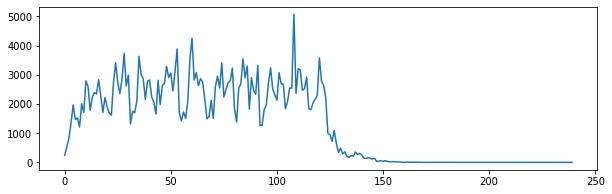

In [11]:
fig = plt.figure(figsize=(10,3))
plt.plot(Flux_month)
print(np.mean(Flux_month[12*5:12*10]))

In [12]:
Flux.shape

(7320, 50)

In [13]:
# iy_idx_total, iz


# Figures 6

In [14]:
Flux_annual = np.mean(Flux[365*5:365*10,:], axis=0)

###

time_lag = 3

it_w1 = 365*5+time_lag
it_w2 = 365*5+4*30+time_lag

it_w3 = 365*7+time_lag
it_w4 = 365*7+4*30+time_lag

it_w5 = 365*9+time_lag
it_w6 = 365*9+4*30+time_lag

N_day_W = it_w6-it_w5 + it_w4-it_w3 + it_w2-it_w1
Flux_W = (np.sum(Flux[it_w1:it_w2,:],axis=0) + np.sum(Flux[it_w3:it_w4,:],axis=0) + np.sum(Flux[it_w5:it_w6,:],axis=0)) / N_day_W

###
it_e1 = 365*6+time_lag
it_e2 = 365*6+4*30+time_lag

it_e3 = 365*8+time_lag
it_e4 = 365*8+4*30+time_lag

N_day_E = it_e4-it_e3 + it_e2-it_e1
Flux_E = (np.sum(Flux[it_e1:it_e2,:],axis=0) + np.sum(Flux[it_e3:it_e4,:],axis=0)) / N_day_E


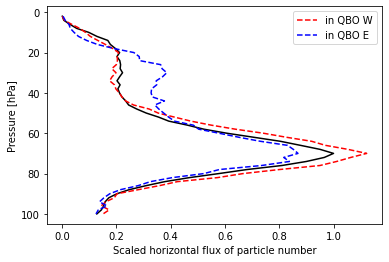

In [15]:

plt.plot(Flux_annual/max(Flux_annual), Levs, 'k')
plt.plot(Flux_W/max(Flux_annual), Levs, 'r--', label='in QBO W')
plt.plot(Flux_E/max(Flux_annual), Levs, 'b--', label='in QBO E')

plt.gca().invert_yaxis()
# plt.yscale('log')

plt.ylabel('Pressure [hPa]')
plt.xlabel('Scaled horizontal flux of particle number')

plt.legend();


[-15 -12  -9  -6  -3   0   3   6   9  12  15] 0 [-15  15]


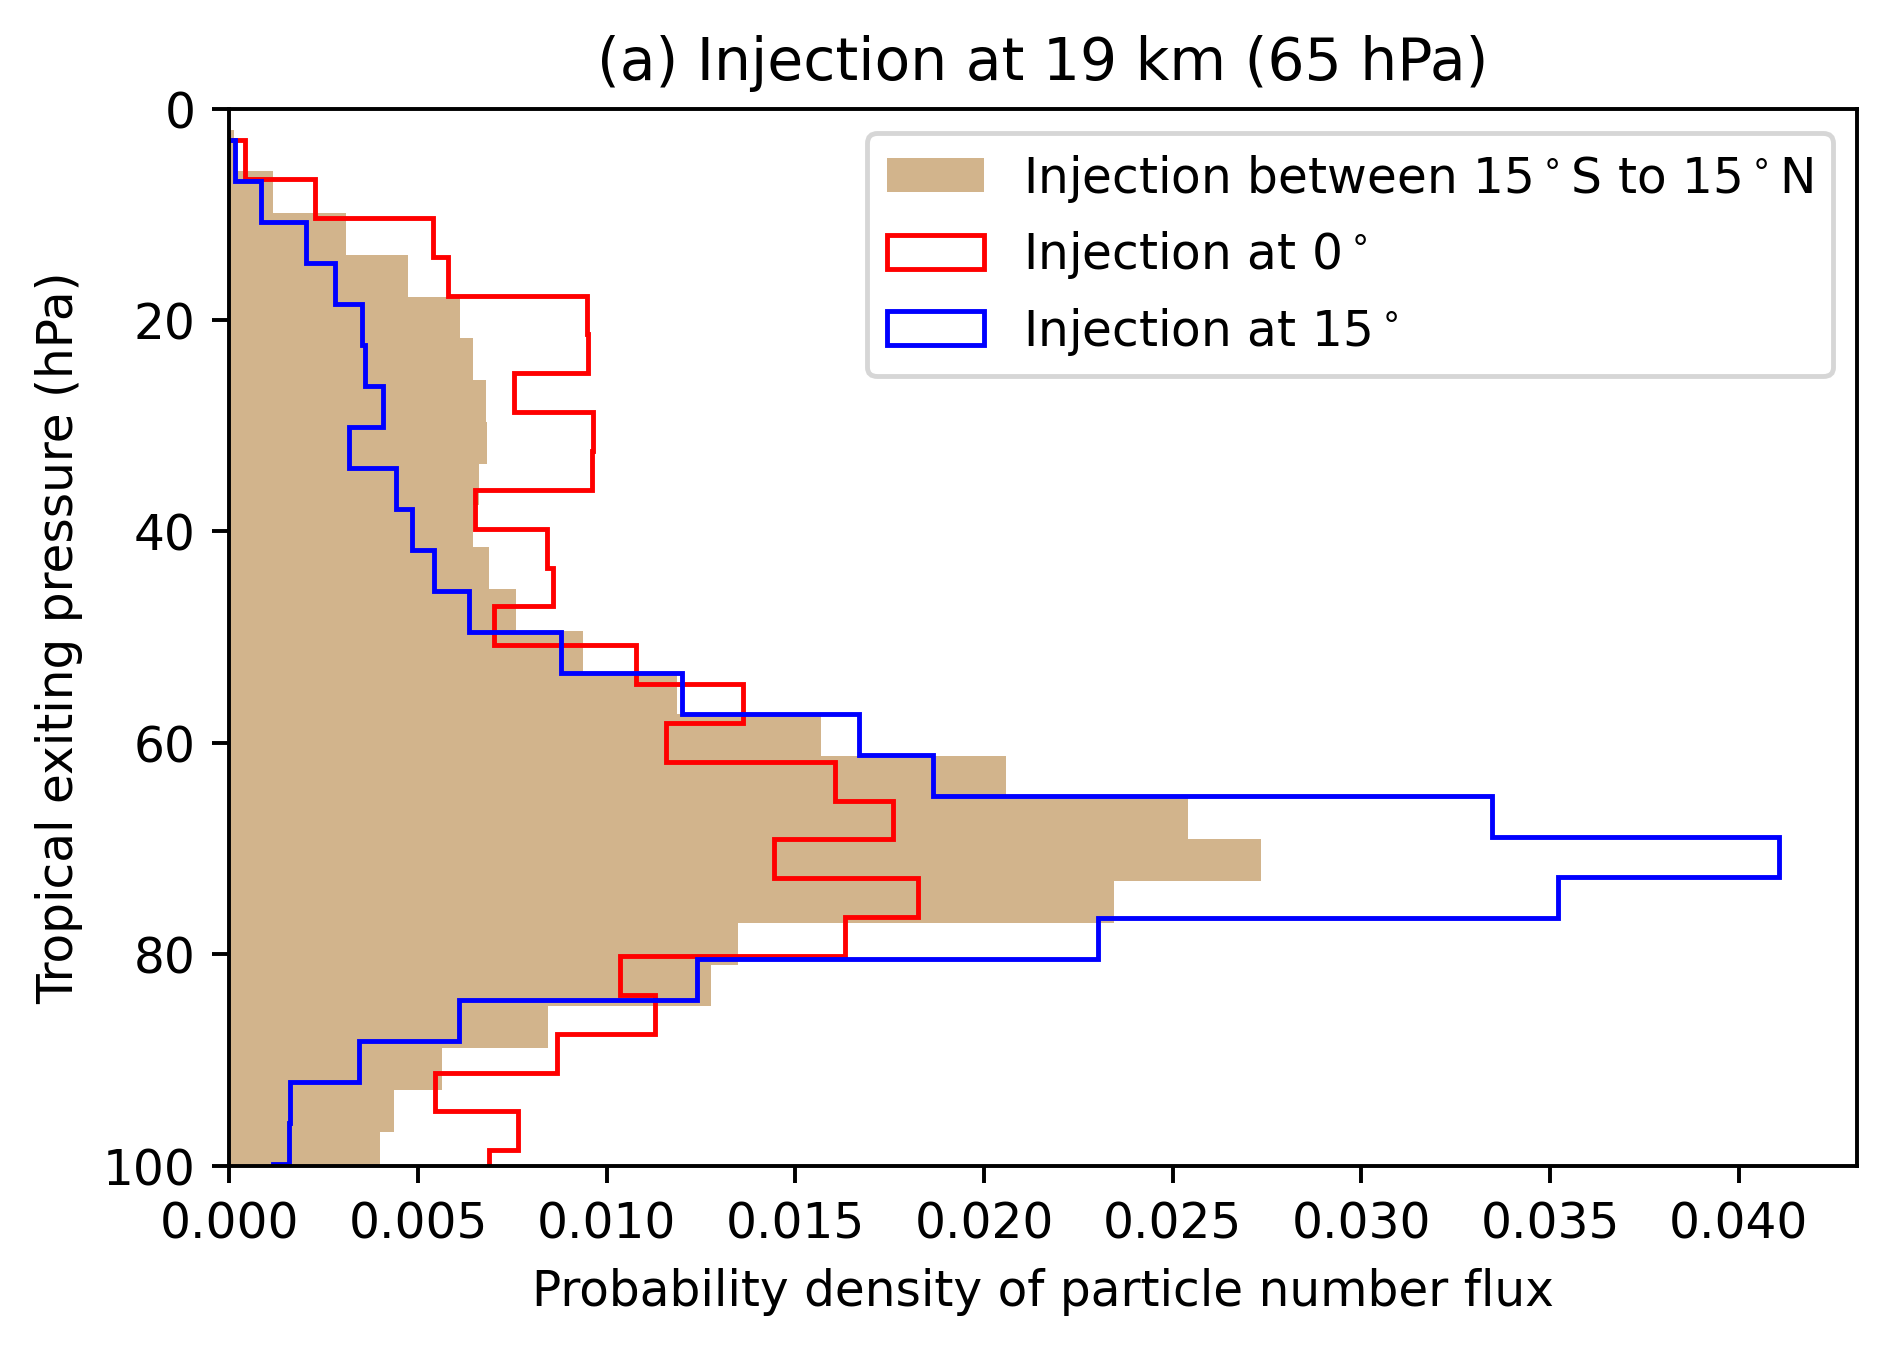

In [24]:
iz = 2
# print(iz, Height[iz], Pressure[iz])
# LEV1_exit = (Nz, Ny, Nx, N_day, N_month, N_year)

# only select initial injection within (15S, 15N)
iy_idx_total = np.arange(5,16,1)
LEV1_exit_1d_total = LEV1_exit[iz,iy_idx_total,:,:,:,:].flatten()

iy_idx_0 = 10
LEV1_exit_1d_0 = LEV1_exit[iz,iy_idx_0,:,:,:,].flatten()

iy_idx_15 = [5,15]
LEV1_exit_1d_15 = LEV1_exit[iz,iy_idx_15,:,:,:,:].flatten()
print(LATs[iy_idx_total], LATs[iy_idx_0], LATs[iy_idx_15])

fig = plt.figure(figsize=(6,4), dpi=350)

plt.hist(LEV1_exit_1d_total, bins=40, density=True, color='tan', orientation='horizontal', label='Injection between $15^\circ$S to $15^\circ$N')
plt.hist(LEV1_exit_1d_0, bins=40, density=True, fill=False, histtype='step', color='r', orientation='horizontal', label='Injection at $0^\circ$')
plt.hist(LEV1_exit_1d_15, bins=40, density=True, fill=False, histtype='step', color='b', orientation='horizontal', label=f'Injection at $15^\circ$')
plt.ylim(0,100)
# plt.xlim(0,0.043)
plt.gca().invert_yaxis()

# plt.plot([0,0.04], [Pressure[iz],Pressure[iz]],  'k--')

plt.title(f"(a) Injection at {Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Probability density of particle number flux")
plt.ylabel("Tropical exiting pressure (hPa)");
plt.legend();

plt.savefig("Figure_6a.jpg")

[-15 -12  -9  -6  -3   0   3   6   9  12  15] 0 [-15  15]


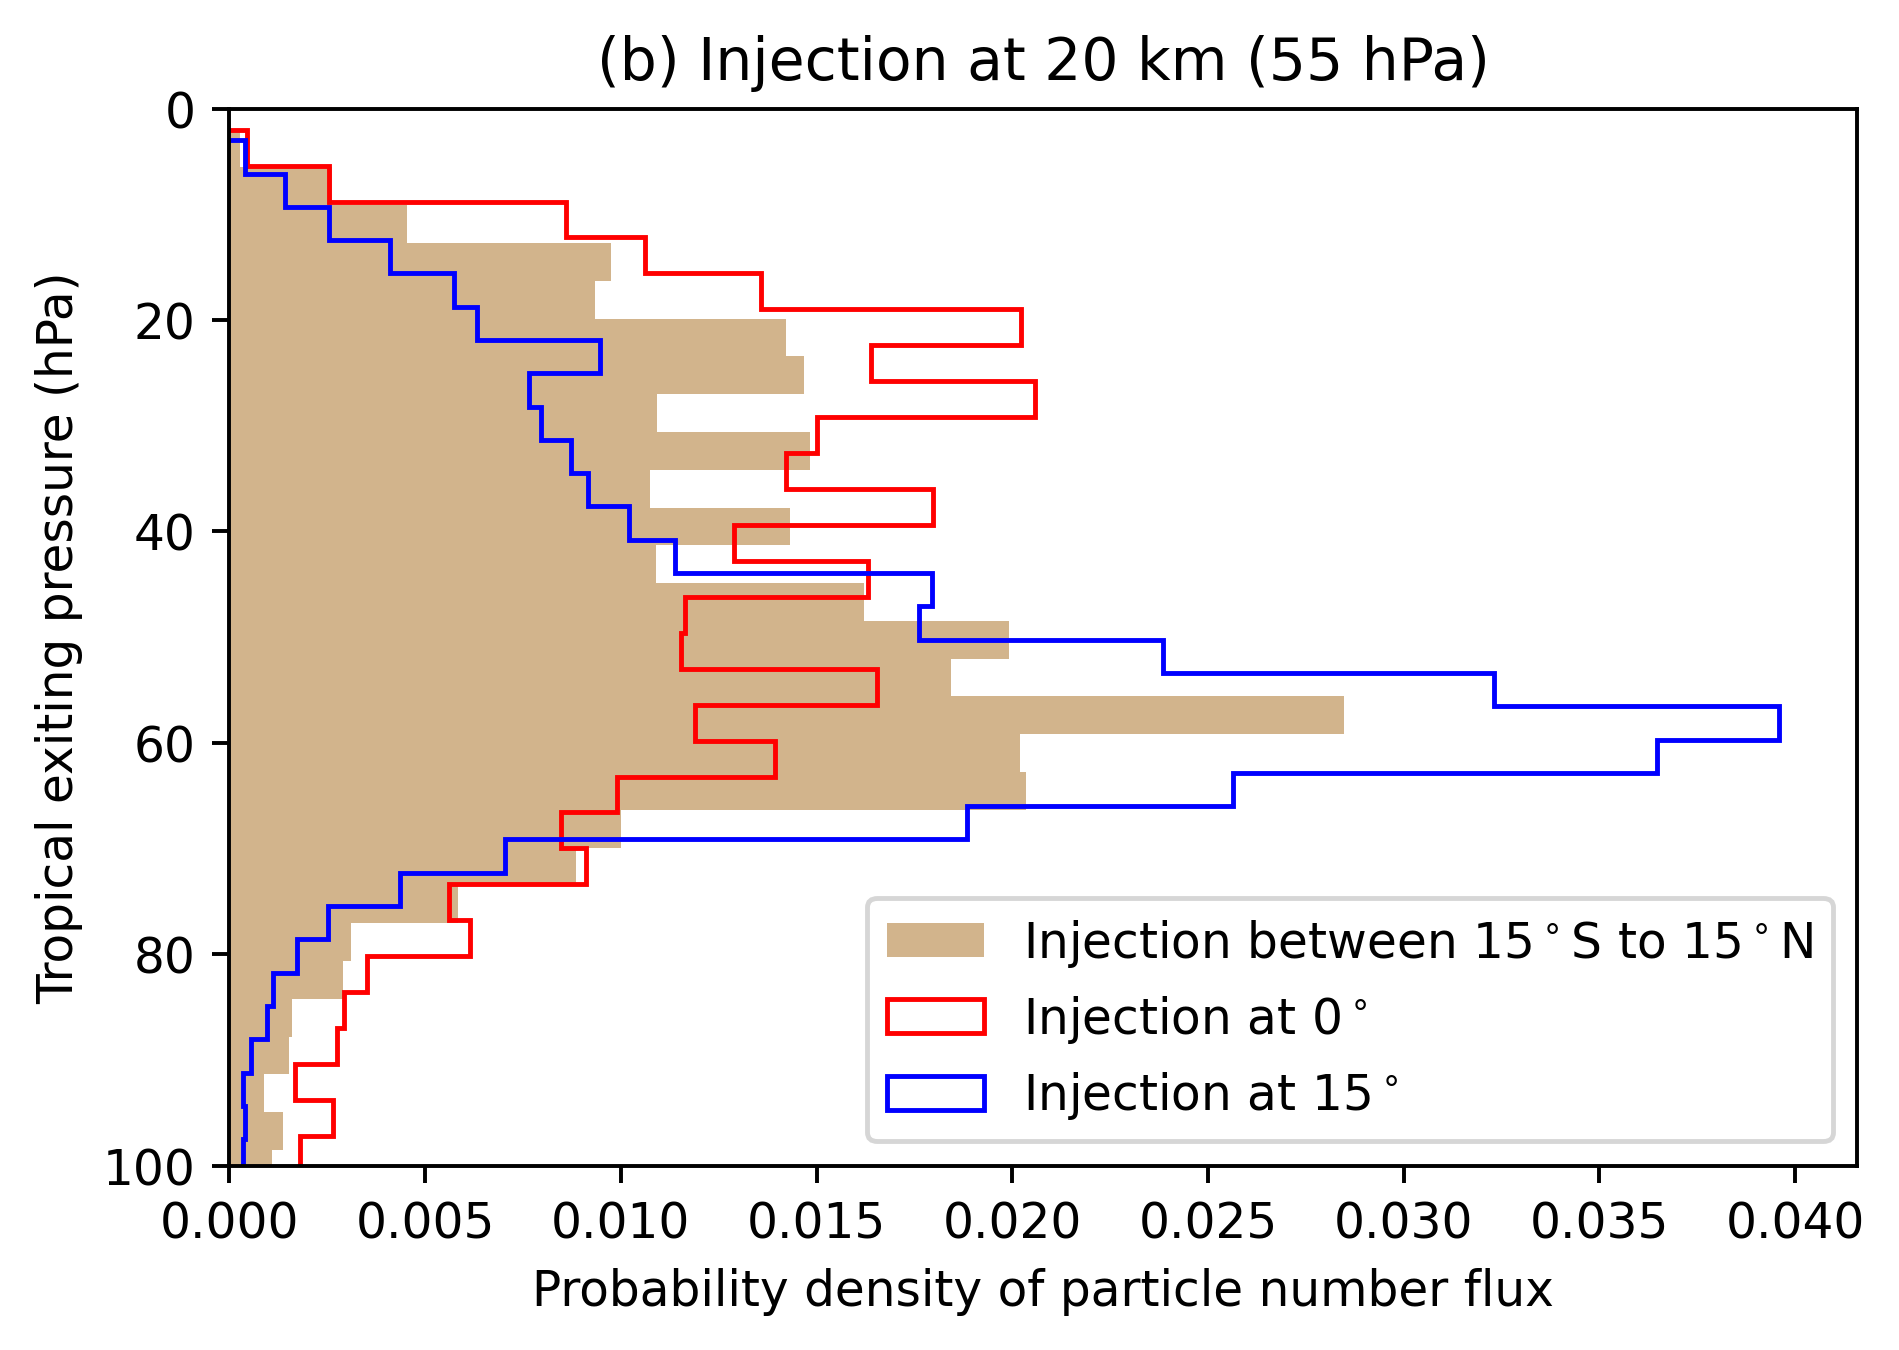

In [25]:
iz = 3
# print(iz, Height[iz], Pressure[iz])
# LEV1_exit = (Nz, Ny, Nx, N_day, N_month, N_year)

# only select initial injection within (15S, 15N)
iy_idx_total = np.arange(5,16,1)
LEV1_exit_1d_total = LEV1_exit[iz,iy_idx_total,:,:,:,:].flatten()

iy_idx_0 = 10
LEV1_exit_1d_0 = LEV1_exit[iz,iy_idx_0,:,:,:,].flatten()

iy_idx_15 = [5,15]
LEV1_exit_1d_15 = LEV1_exit[iz,iy_idx_15,:,:,:,:].flatten()
print(LATs[iy_idx_total], LATs[iy_idx_0], LATs[iy_idx_15])

fig = plt.figure(figsize=(6,4), dpi=350)

plt.hist(LEV1_exit_1d_total, bins=40, density=True, color='tan', orientation='horizontal', label='Injection between $15^\circ$S to $15^\circ$N')
plt.hist(LEV1_exit_1d_0, bins=40, density=True, fill=False, histtype='step', color='r', orientation='horizontal', label='Injection at $0^\circ$')
plt.hist(LEV1_exit_1d_15, bins=40, density=True, fill=False, histtype='step', color='b', orientation='horizontal', label=f'Injection at $15^\circ$')
plt.ylim(0,100)
# plt.xlim(0,0.043)
plt.gca().invert_yaxis()

# plt.plot([0,0.04], [Pressure[iz],Pressure[iz]],  'k--')

plt.title(f"(b) Injection at {Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Probability density of particle number flux")
plt.ylabel("Tropical exiting pressure (hPa)");
plt.legend();

plt.savefig("Figure_6b.jpg")

# Figure 6

[-15 -12  -9  -6  -3   0   3   6   9  12  15] 0 [-15  15]


/n/home12/hongwei/.conda/envs/SUNenv/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


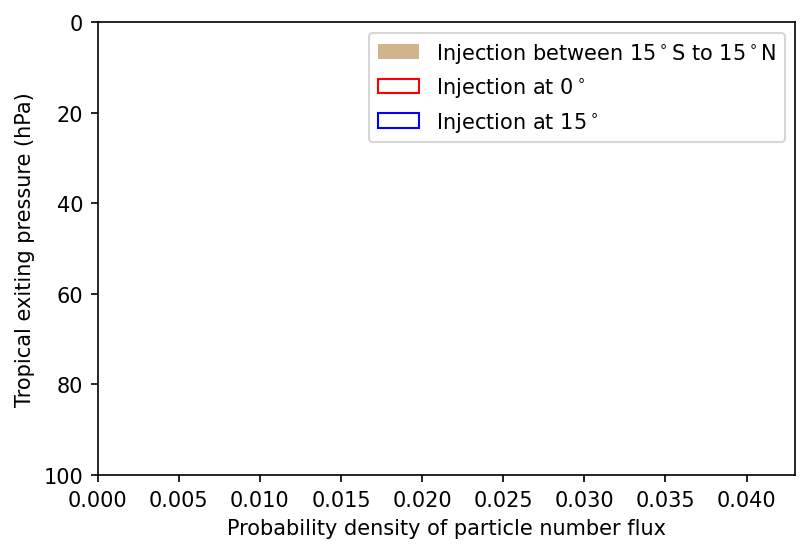

In [19]:
iz = 2
# print(iz, Height[iz], Pressure[iz])


# only select initial injection within (15S, 15N)
iy_idx_total = np.arange(5,16,1)
LEV1_exit_1d_total = LEV1_exit[iz,iy_idx_total,:,:,:,2000:2005].flatten()

it_w1 = 365*5
it_w2 = 365*5+5*30

it_w3 = 365*6+6*30
it_w4 = 365*7+5*30

it_w5 = 365*8+7*30
it_w6 = 365*9+9*30

N_day_W = it_w6-it_w5 + it_w4-it_w3 + it_w2-it_w1
LEV1_exit_1d_0 = LEV1_exit[iz,iy_idx_0,:,:,:,2000:2005].flatten()

# it_idx_QBO_W = 
LEV1_exit_1d_15 = LEV1_exit[iz,iy_idx_15,:,:,:,2000:2005].flatten()
print(LATs[iy_idx_total], LATs[iy_idx_0], LATs[iy_idx_15])



fig = plt.figure(figsize=(6,4), dpi=150)

plt.hist(LEV1_exit_1d_total, bins=40, density=True, color='tan', orientation='horizontal', label='Injection between $15^\circ$S to $15^\circ$N')
plt.hist(LEV1_exit_1d_0, bins=40, density=True, fill=False, histtype='step', color='r', orientation='horizontal', label='Injection at $0^\circ$')
plt.hist(LEV1_exit_1d_15, bins=40, density=True, fill=False, histtype='step', color='b', orientation='horizontal', label=f'Injection at $15^\circ$')
plt.ylim(0,100)
plt.xlim(0,0.043)
plt.gca().invert_yaxis()

# plt.plot([0,0.04], [Pressure[iz],Pressure[iz]],  'k--')

# plt.title(f"Injection at {Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Probability density of particle number flux")
plt.ylabel("Tropical exiting pressure (hPa)");
plt.legend();

# Stop here

# number flux exiting tropics above/below 50hPa

In [13]:


# for i_year in tqdm(range(N_year)):
    
#     Num_2D_temp = np.zeros((N_lat, N_lon, N_lev, N_day)) 
#     for i_day in range(N_day):
#         for ix in range(N_lon):
#             for iy in range(N_lat):
#                 ii = i_day*(N_lat*N_lon) + ix*N_lat + iy
#                 Num_2D_temp[iy, ix, :, i_day] = NUMs[ii,:]
    
    

    

## Figure 3: Number flux from tropics to mid-lat 

In [64]:
# only select initial injection within (15S, 15N)

iy_idx = np.arange(5,16,1)
iy_idx = 10
print(LATs[iy_idx])

0


In [65]:
# LEV1_exit = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

iz = 2

# LEV1_exit2 = LEV1_exit[iz,:,:,:,:,5:10]
# print(LEV1_exit2.shape)

Num1 = []
Num2 = []

Num3 = []
Num4 = []

P_ref = 50.0
for iyr in range(5,10,1):
    for imon in range(N_month):
        for iday in range(N_day):
            
            LEV1_exit_1d = LEV1_exit[iz,iy_idx,:,iday,imon,iyr].flatten()
            LAT1_exit_1d = LAT1_exit[iz,iy_idx,:,iday,imon,iyr].flatten()
            
            idx1 = [idx for idx, val in enumerate(LEV1_exit_1d) if val < P_ref]
            idx2 = [idx for idx, val in enumerate(LEV1_exit_1d) if val >= P_ref]
            
            idx3 = [idx for idx, val in enumerate(LAT1_exit_1d) if abs(val) < 29.99]
            idx4 = [idx for idx, val in enumerate(LAT1_exit_1d) if abs(val) > 29.99]
            
            Num1.append(len(idx1))
            Num2.append(len(idx2))
            
            Num3.append(len(idx3))
            Num4.append(len(idx4))            
            
np.sum(Num1)

4482

In [66]:
total = np.mean(Num1)+np.mean(Num2)

print(f"The number flux from upper tropical stratosphere to mid is {np.mean(Num1)/total:.3f}")

np.mean(Num1), np.mean(Num2), np.mean(Num1)/total, np.mean(Num2)/total, np.mean(Num1)+np.mean(Num2)

The number flux from upper tropical stratosphere to mid is 0.311


(7.47, 16.53, 0.31124999999999997, 0.6887500000000001, 24.0)

### sink in the tropical tropopause

In [17]:
np.mean(Num3), np.mean(Num4)

(5.468333333333334, 258.5316666666667)

In [18]:
idx3

[215]

## Different lat vs. tropical exiting pressure

In [19]:
# LEV1_exit = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

iz = 2

# LEV1_exit2 = LEV1_exit[iz,:,:,:,:,5:10]
# print(LEV1_exit2.shape)

Num11 = np.zeros((Ny,5*N_month*N_day))
Num22 = np.zeros((Ny,5*N_month*N_day))

Num33 = np.zeros((Ny,5*N_month*N_day))
Num44 = np.zeros((Ny,5*N_month*N_day))

P_ref = 50
it = 0
for iyr in range(5,10,1):
    for imon in range(N_month):
        for iday in range(N_day):
            for iy in range(Ny):
            
                LEV1_exit_1d = LEV1_exit[iz,iy,:,iday,imon,iyr].flatten()
                LAT1_exit_1d = LAT1_exit[iz,iy,:,iday,imon,iyr].flatten()
            
                idx11 = [idx for idx, val in enumerate(LEV1_exit_1d) if val < P_ref]
                idx22 = [idx for idx, val in enumerate(LEV1_exit_1d) if val >= P_ref]
            
                idx33 = [idx for idx, val in enumerate(LAT1_exit_1d) if abs(val) < 29.99]
                idx44 = [idx for idx, val in enumerate(LAT1_exit_1d) if abs(val) > 29.99]
            
                Num11[iy,it] = len(idx11)
                Num22[iy,it] = len(idx22)
            
                Num33[iy,it] = len(idx33)
                Num44[iy,it] = len(idx44)  
                
            it = it+1
            
np.sum(Num1)

38025

In [20]:
it, 5*N_month*N_day

(600, 600)

In [21]:
Num11.shape

(21, 600)

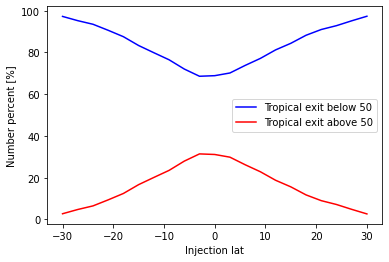

In [33]:
Num11_mean = np.mean(Num11,axis=1)
Num22_mean = np.mean(Num22,axis=1)
total_mean = Num11_mean + Num22_mean

plt.plot(LATs, 100*Num22_mean/total_mean, 'b-', label=f'Tropical exit below {P_ref}');
plt.plot(LATs, 100*Num11_mean/total_mean, 'r-', label=f'Tropical exit above {P_ref}')

plt.xlabel("Injection lat")
plt.ylabel("Number percent [%]")
plt.legend();

In [34]:
Num11_mean_sum = np.sum(Num11_mean[iy_idx]) 
Num22_mean_sum = np.sum(Num22_mean[iy_idx])

print(iy_idx, LATs[iy_idx])
print(Num11_mean_sum, Num22_mean_sum, Num11_mean_sum/(Num11_mean_sum+Num22_mean_sum), Num22_mean_sum/(Num11_mean_sum+Num22_mean_sum))

[ 5  6  7  8  9 10 11 12 13 14 15] [-15 -12  -9  -6  -3   0   3   6   9  12  15]
63.37500000000001 200.625 0.2400568181818182 0.7599431818181818


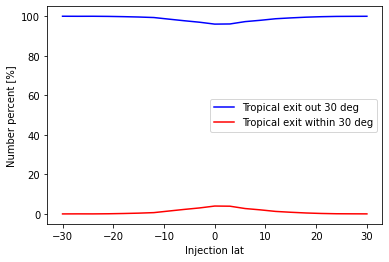

In [35]:
Num33_mean = np.mean(Num33,axis=1)
Num44_mean = np.mean(Num44,axis=1)
total_mean = Num33_mean + Num44_mean

plt.plot(LATs, 100*Num44_mean/total_mean, 'b-', label=f'Tropical exit out 30 deg');
plt.plot(LATs, 100*Num33_mean/total_mean, 'r-', label=f'Tropical exit within 30 deg')

plt.xlabel("Injection lat")
plt.ylabel("Number percent [%]")
plt.legend();

In [36]:
Num33_mean_sum = np.sum(Num33_mean[iy_idx]) 
Num44_mean_sum = np.sum(Num44_mean[iy_idx])

print(iy_idx, LATs[iy_idx])
print(Num33_mean_sum, Num44_mean_sum, Num33_mean_sum/(Num33_mean_sum+Num44_mean_sum), Num44_mean_sum/(Num33_mean_sum+Num44_mean_sum))

[ 5  6  7  8  9 10 11 12 13 14 15] [-15 -12  -9  -6  -3   0   3   6   9  12  15]
5.468333333333334 258.5316666666667 0.02071338383838384 0.9792866161616163


# Discussion: for injection only at equator

In [28]:
Num11_mean_sum = np.sum(Num11_mean[10]) 
Num22_mean_sum = np.sum(Num22_mean[10])

print(10, LATs[10])
print(Num11_mean_sum, Num22_mean_sum, Num11_mean_sum/(Num11_mean_sum+Num22_mean_sum), Num22_mean_sum/(Num11_mean_sum+Num22_mean_sum))

10 0
7.47 16.53 0.31124999999999997 0.6887500000000001


In [31]:
print(f"But we have test that even for particles only injected at the equator (0 deg),")
print(f"there are more horizontal transport (**%) than upward transport ({Num11_mean_sum/(Num11_mean_sum+Num22_mean_sum):.2f}).")

But we have test that even for particles only injected at the equator (0 deg),
there are more horizontal transport (**%) than upward transport (0.31).


In [38]:
Num33_mean_sum = np.sum(Num33_mean[10]) 
Num44_mean_sum = np.sum(Num44_mean[10])

print(10, LATs[10])
print(Num33_mean_sum, Num44_mean_sum, Num33_mean_sum/(Num33_mean_sum+Num44_mean_sum), Num44_mean_sum/(Num33_mean_sum+Num44_mean_sum))

10 0
0.96 23.04 0.04 0.96


In [40]:
print(f"But we have test that even for particles only injected at the equator (0 deg),")
print(f"get into mid-lat: ({Num33_mean_sum/(Num33_mean_sum+Num44_mean_sum):.2f}); get into tropopause: ({Num44_mean_sum/(Num33_mean_sum+Num44_mean_sum):.2f}).")

But we have test that even for particles only injected at the equator (0 deg),
get into mid-lat: (0.04); get into tropopause: (0.96).


## Tropical exiting lev: annual change

18.87 65
Stratospheric lifetime: 3.2 year (Higher than 50 hPa), 1.4 year (Lower than 50 hPa)
Particle number: 0.16431712962962963 year (Higher than 50 hPa), 0.8356828703703704 year (Lower than 50 hPa)


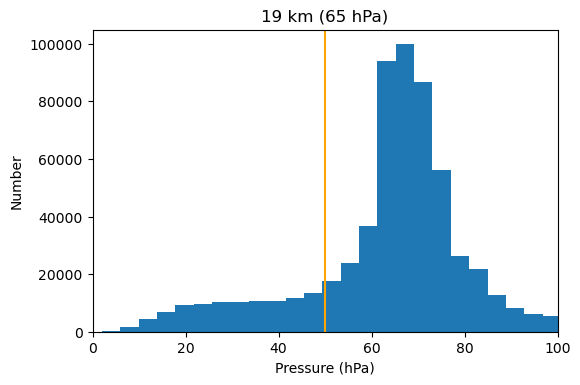

In [9]:
# LEV1_final = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

iz = 2

iy1 = 0
iy2 = Ny
print(Height[iz], Pressure[iz])

LEV1_exit_1d = LEV1_exit[iz,:,:,:,:,:].flatten()
lifetime2_1d = lifetime2[iz,:,:,:,:,:].flatten()
LAT2_sink_1d = LAT2_sink[iz,:,:,:,:,:].flatten()

fig = plt.figure(dpi=100)

plt.hist(LEV1_exit_1d, bins=40, label="LEV")
plt.xlim(0,100)

plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Number");


plt.axvline(x = 50, color='orange')
# plt.legend()


P_ref = 50

idx1 = [idx for idx, val in enumerate(LEV1_exit_1d) if val < P_ref]
idx2 = [idx for idx, val in enumerate(LEV1_exit_1d) if val >= P_ref]

print(f"Stratospheric lifetime: {np.mean(lifetime2_1d[idx1])/365.25:.1f} year (Higher than {P_ref} hPa), \
{np.mean(lifetime2_1d[idx2])/365.25:.1f} year (Lower than {P_ref} hPa)")

print(f"Particle number: { len(idx1) / (len(idx1)+len(idx2)) } year (Higher than {P_ref} hPa), \
{ len(idx2) / (len(idx1)+len(idx2)) } year (Lower than {P_ref} hPa)")



18.87 65


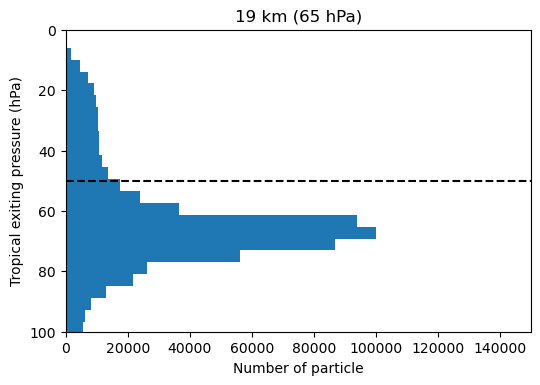

In [10]:
iz = 2
print(Height[iz], Pressure[iz])

LEV1_exit_1d = LEV1_exit[iz,:,:,:,:,:].flatten()
lifetime2_1d = lifetime2[iz,:,:,:,:,:].flatten()
LAT2_sink_1d = LAT2_sink[iz,:,:,:,:,:].flatten()

fig = plt.figure(dpi=100)

plt.hist(LEV1_exit_1d, bins=40, label="LEV", orientation='horizontal')
plt.ylim(0,100)
plt.xlim(0,150000)
plt.gca().invert_yaxis()

plt.plot([0,150000], [50,50],  'k--')

plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Number of particle")
plt.ylabel("Tropical exiting pressure (hPa)");

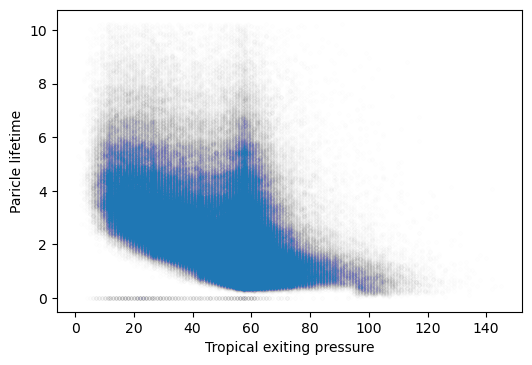

In [13]:
# LON1_exit = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

iz =3
iy1 = 1
iy2 = -1

fig = plt.figure(dpi=100)

plt.plot(LEV1_exit[iz,iy1:iy2,:,:,:,:].flatten(), lifetime2[iz,iy1:iy2,:,:,:,:].flatten()/356.25, '.', alpha=0.005);
plt.xlabel("Tropical exiting pressure")
plt.ylabel("Paricle lifetime");


In [14]:
LEV1_exit[iz,:,:,:,:,:].shape

(21, 24, 10, 12, 10)

In [15]:
print(f"Stratospheric lifetime: {np.mean(abs(LAT2_sink_1d[idx1])):.1f} (Higher than 40 hPa), \
{np.mean(abs(LAT2_sink_1d[idx2])):.1f} (Lower than 40 hPa)")

Stratospheric lifetime: 43.2 (Higher than 40 hPa), 42.9 (Lower than 40 hPa)


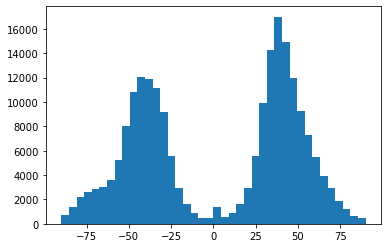

In [16]:
plt.hist(LAT2_sink_1d[idx1], bins=40);

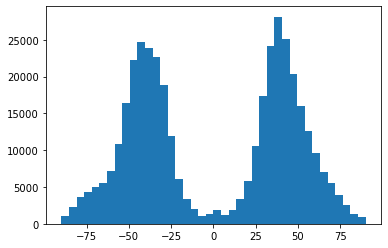

In [17]:
plt.hist(LAT2_sink_1d[idx2], bins=40);

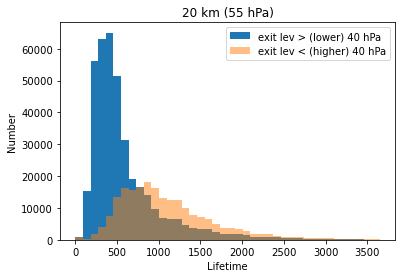

In [18]:
plt.hist(lifetime2_1d[idx2], bins=40, label="exit lev > (lower) 40 hPa")
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Number");


plt.hist(lifetime2_1d[idx1], bins=40, label="exit lev < (higher) 40 hPa", alpha=0.5)
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Lifetime")
plt.ylabel("Number");

plt.legend();

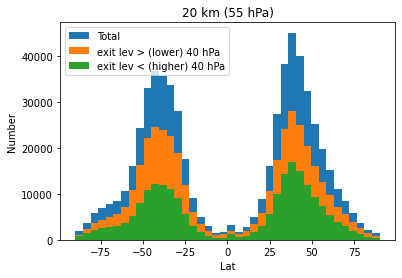

In [19]:
plt.hist(LAT2_sink_1d, bins=40, label="Total")
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Number");


plt.hist(LAT2_sink_1d[idx2], bins=40, label="exit lev > (lower) 40 hPa")
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Number");


plt.hist(LAT2_sink_1d[idx1], bins=40, label="exit lev < (higher) 40 hPa")
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Lat")
plt.ylabel("Number");

plt.legend();

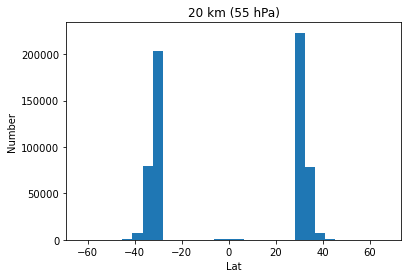

In [20]:
plt.hist(LAT1_exit[iz,:,:,:,:,:].flatten(), bins=30, label="LAT");

plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Lat")
plt.ylabel("Number");

## Tropical exiting lev: seasonal change

20 55


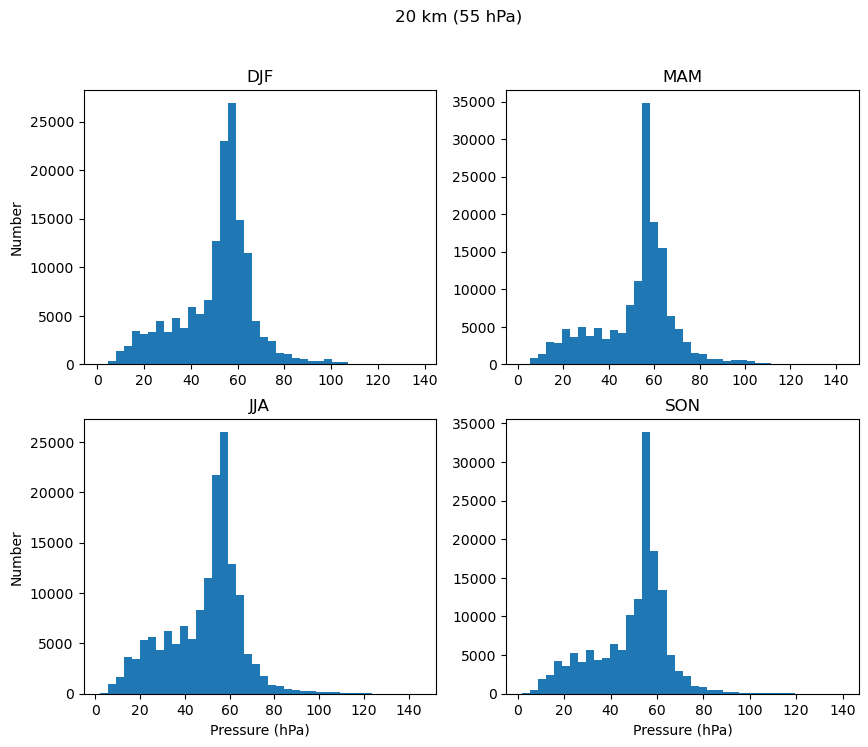

In [21]:
print(Height[iz], Pressure[iz])

fig = plt.figure(figsize=(10,8), dpi=100)

plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")

ax1 = plt.subplot(2,2,1)
ax1.hist(LEV1_exit[iz,:,:,:,[11,0,1],:].flatten(), bins=40, label="LEV")
ax1.set_title(f"DJF")
# ax1.set_xlabel("Pressure (hPa)")
ax1.set_ylabel("Number");


ax2 = plt.subplot(2,2,2)
ax2.hist(LEV1_exit[iz,:,:,:,[2,3,4],:].flatten(), bins=40, label="LEV")
ax2.set_title(f"MAM")
# ax2.set_xlabel("Pressure (hPa)")
# ax2.set_ylabel("Number");


ax3 = plt.subplot(2,2,3)
ax3.hist(LEV1_exit[iz,:,:,:,[5,6,7],:].flatten(), bins=40, label="LEV")
ax3.set_title(f"JJA")
ax3.set_xlabel("Pressure (hPa)")
ax3.set_ylabel("Number");


ax4 = plt.subplot(2,2,4)
ax4.hist(LEV1_exit[iz,:,:,:,[8,9,10],:].flatten(), bins=40, label="LEV")
ax4.set_title(f"SON")
ax4.set_xlabel("Pressure (hPa)")
# ax4.set_ylabel("Number");

fig.suptitle(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)");


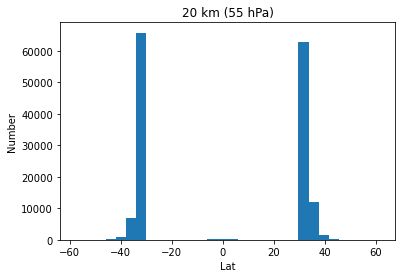

In [22]:
plt.hist(LAT1_exit[iz,:,:,:,[-1,0,1],:].flatten(), bins=30, label="LAT");

plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Lat")
plt.ylabel("Number");

## Strotospheric sink lat: 

20 55


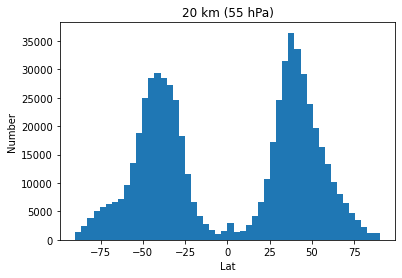

In [23]:
iz = 3
print(Height[iz], Pressure[iz])
plt.hist(LAT2_sink[iz,:,:,:,:,:].flatten(), bins=50, label="LAT")
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Lat")
plt.ylabel("Number");

## Stratopheric sink lat vs. lifetime

In [24]:
# LEV1_final = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

iz = 3
print(Height[iz], Pressure[iz])

LEV1_exit_1d = LEV1_exit[iz,:,:,:,:,:].flatten()
lifetime2_1d = lifetime2[iz,:,:,:,:,:].flatten()
LAT2_sink_1d = LAT2_sink[iz,:,:,:,:,:].flatten()

# plt.hist(LEV1_exit_1d, bins=40, label="LEV")
# plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
# plt.xlabel("Pressure (hPa)")
# plt.ylabel("Number");

idx1 = [idx for idx, val in enumerate(LAT2_sink_1d) if val < -62.5]
idx2 = [idx for idx, val in enumerate(LAT2_sink_1d) if 0 > val >= -62.5]

print(f"Stratospheric lifetime: {np.mean(lifetime2_1d[idx1]):.1f} (<-62.5), \
{np.mean(lifetime2_1d[idx2]):.1f} (0 to -62.5)")

print(f"Stratospheric lifetime: {np.mean(LEV1_exit_1d[idx1]):.1f} (<-62.5), \
{np.mean(LEV1_exit_1d[idx2]):.1f} (0 to -62.5)")

20 55
Stratospheric lifetime: 886.8 (<-62.5), 785.8 (0 to -62.5)
Stratospheric lifetime: 49.0 (<-62.5), 51.1 (0 to -62.5)


In [25]:
print(f"Stratospheric lifetime: {np.median(LEV1_exit_1d[idx1]):.1f} (<-62.5), \
{np.median(LEV1_exit_1d[idx2]):.1f} (0 to -62.5)")

Stratospheric lifetime: 55.0 (<-62.5), 55.0 (0 to -62.5)


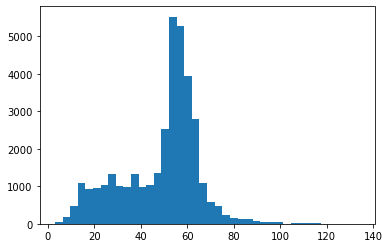

In [26]:
plt.hist(LEV1_exit_1d[idx1], bins=40);


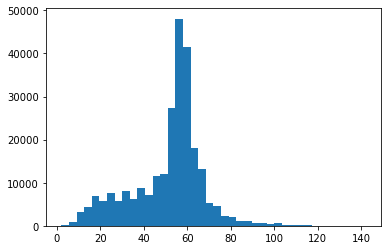

In [27]:
plt.hist(LEV1_exit_1d[idx2], bins=40);

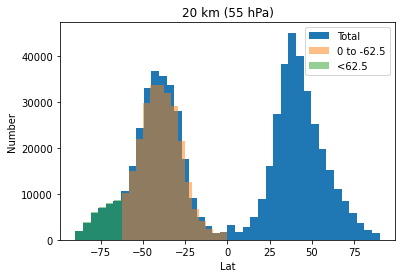

In [28]:
plt.hist(LAT2_sink_1d, bins=40, label="Total")
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Number");


plt.hist(LAT2_sink_1d[idx2], bins=15, label="0 to -62.5", alpha=0.5)
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Number");


plt.hist(LAT2_sink_1d[idx1], bins=6, label="<62.5", alpha=0.5)
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Lat")
plt.ylabel("Number");

plt.legend();

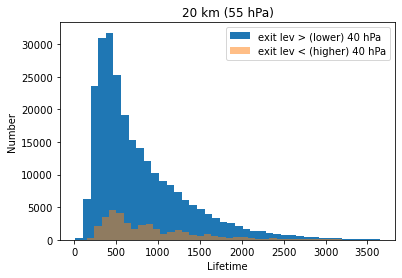

In [29]:
plt.hist(lifetime2_1d[idx2], bins=40, label="exit lev > (lower) 40 hPa")
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Number");


plt.hist(lifetime2_1d[idx1], bins=40, label="exit lev < (higher) 40 hPa", alpha=0.5)
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Lifetime")
plt.ylabel("Number");

plt.legend();

## Tropopause sink at different sink seasons

In [30]:
11%4

3

## Tropopause sink at different injection seasons

In [31]:
LAT2_sink2_DJF = []
LAT2_sink2_MAM = []
LAT2_sink2_JJA = []
LAT2_sink2_SON = []

iz=3

for iyr in range(N_year):
    for imon in range(N_month):
        for iday in range(N_day):
            for ix in range(Nx):
                for iy in range(Ny):
            
                        days = lifetime2[iz,iy,ix,iday,imon,iyr] + 30*imon + iday
                        iseason = int( ( (days+30)%365 )/91 )
                    
                        if iseason ==0:
                            LAT2_sink2_DJF.append(LAT2_sink[iz,iy,ix,iday,imon,iyr])
                        if iseason ==1:
                            LAT2_sink2_MAM.append(LAT2_sink[iz,iy,ix,iday,imon,iyr])
                        if iseason ==2:
                            LAT2_sink2_JJA.append(LAT2_sink[iz,iy,ix,iday,imon,iyr])
                        if iseason ==3:
                            LAT2_sink2_SON.append(LAT2_sink[iz,iy,ix,iday,imon,iyr])

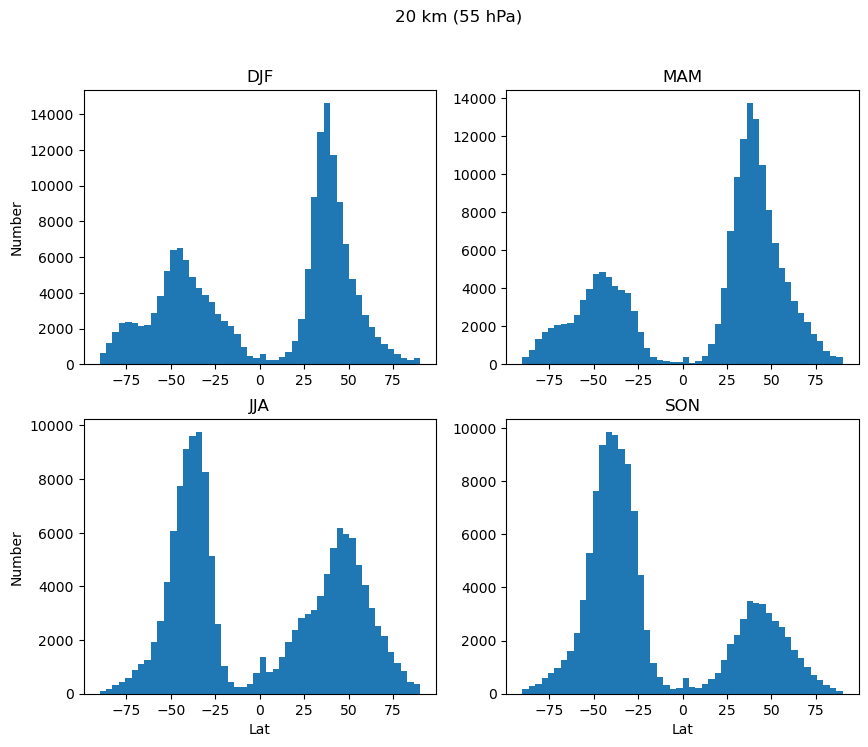

In [32]:
fig = plt.figure(figsize=(10,8), dpi=100)

plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")

ax1 = plt.subplot(2,2,1)
ax1.hist(LAT2_sink2_DJF, bins=50, label="LAT")
ax1.set_title(f"DJF")
# ax1.set_xlabel("Pressure (hPa)")
ax1.set_ylabel("Number");


ax2 = plt.subplot(2,2,2)
ax2.hist(LAT2_sink2_MAM, bins=50, label="LAT")
ax2.set_title(f"MAM")
# ax2.set_xlabel("Pressure (hPa)")
# ax2.set_ylabel("Number");


ax3 = plt.subplot(2,2,3)
ax3.hist(LAT2_sink2_JJA, bins=50, label="LAT")
ax3.set_title(f"JJA")
ax3.set_xlabel("Lat")
ax3.set_ylabel("Number");


ax4 = plt.subplot(2,2,4)
ax4.hist(LAT2_sink2_SON, bins=50, label="LAT")
ax4.set_title(f"SON")
ax4.set_xlabel("Lat")
# ax4.set_ylabel("Number");

fig.suptitle(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)");


20 55


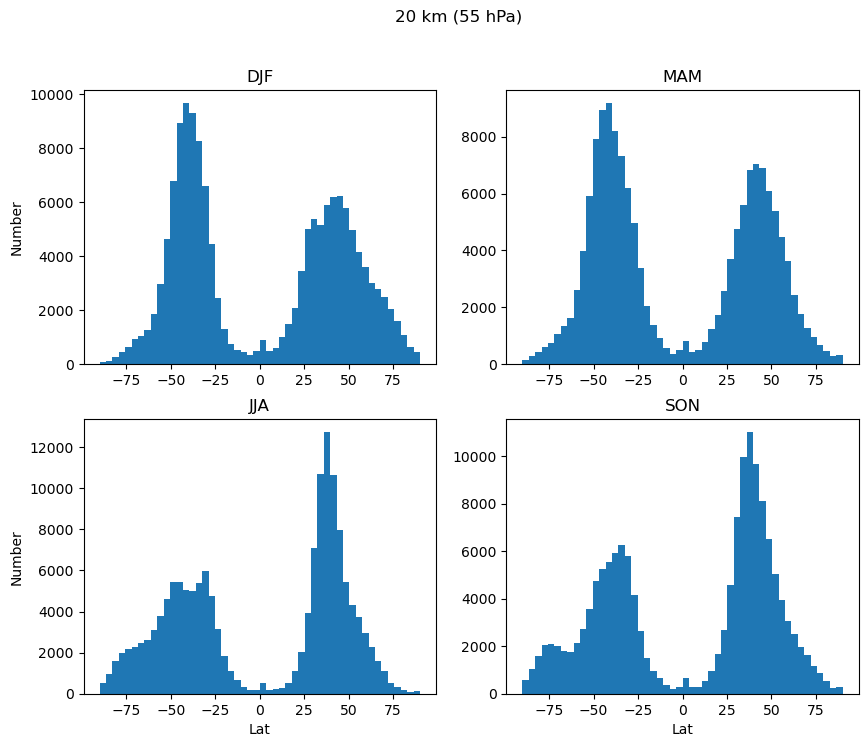

In [33]:
print(Height[iz], Pressure[iz])

fig = plt.figure(figsize=(10,8), dpi=100)

plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")

ax1 = plt.subplot(2,2,1)
ax1.hist(LAT2_sink[iz,:,:,:,[-1,0,1],:].flatten(), bins=50, label="LAT")
ax1.set_title(f"DJF")
# ax1.set_xlabel("Pressure (hPa)")
ax1.set_ylabel("Number");


ax2 = plt.subplot(2,2,2)
ax2.hist(LAT2_sink[iz,:,:,:,[2,3,4],:].flatten(), bins=50, label="LAT")
ax2.set_title(f"MAM")
# ax2.set_xlabel("Pressure (hPa)")
# ax2.set_ylabel("Number");


ax3 = plt.subplot(2,2,3)
ax3.hist(LAT2_sink[iz,:,:,:,[5,6,7],:].flatten(), bins=50, label="LAT")
ax3.set_title(f"JJA")
ax3.set_xlabel("Lat")
ax3.set_ylabel("Number");


ax4 = plt.subplot(2,2,4)
ax4.hist(LAT2_sink[iz,:,:,:,[8,9,10],:].flatten(), bins=50, label="LAT")
ax4.set_title(f"SON")
ax4.set_xlabel("Lat")
# ax4.set_ylabel("Number");

fig.suptitle(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)");


## QBO influence

In [34]:
Year_W = [2,4,6,8]
Month_W = [[4,5,6,7,8,9], [5,6,7,8,9], [6,7,8,9], [6,7]]

Year_E = [1,3,5,7]
Month_E = [[5,6,7], [6,7,8,9], [6,7,8,9,10], [6,7,8,9,10]]

Month_W[0][:]

[4, 5, 6, 7, 8, 9]

In [35]:
iz = 3

LEV1_exit_W = []
LEV1_exit_E = []

lifetime2_W = []
lifetime2_E = []

LAT2_sink_W = []
LAT2_sink_E = []

# LEV1_exit_1d = LEV1_exit[iz,:,:,:,:,:].flatten()
# lifetime2_1d = lifetime2[iz,:,:,:,:,:].flatten()
# LAT2_sink_1d = LAT2_sink[iz,:,:,:,:,:].flatten()

# total
for iyr in range(4):
    data1 = LEV1_exit[iz,:,:,:,Month_W[iyr][:],Year_W[iyr]].flatten()
    data2 = lifetime2[iz,:,:,:,Month_W[iyr][:],Year_W[iyr]].flatten()
    data3 = LAT2_sink[iz,:,:,:,Month_W[iyr][:],Year_W[iyr]].flatten()
    for idx in range(len(data1)):
        LEV1_exit_W.append(data1[idx])
        lifetime2_W.append(data2[idx])
        LAT2_sink_W.append(data3[idx])
        
    data1 = LEV1_exit[iz,:,:,:,Month_E[iyr][:],Year_E[iyr]].flatten()
    data2 = lifetime2[iz,:,:,:,Month_E[iyr][:],Year_E[iyr]].flatten()
    data3 = LAT2_sink[iz,:,:,:,Month_E[iyr][:],Year_E[iyr]].flatten()
    for idx in range(len(data1)):
        LEV1_exit_E.append(data1[idx])
        lifetime2_E.append(data2[idx])
        LAT2_sink_E.append(data3[idx])


# # moderate El Nino
# iyr=0
# data = LEV1_exit[iz,:,:,:,Month_W[iyr][:],Year_W[iyr]].flatten()
# for i in data:
#     LEV1_exit_W.append(i)
        
# iyr=1
# data = LEV1_exit[iz,:,:,:,Month_E[iyr][:],Year_E[iyr]].flatten()
# for i in data:
#     LEV1_exit_E.append(i)
    
    
# # weak La Nina
# iyr=8
# data = LEV1_exit[iz,:,:,:,Month_W[iyr][:],Year_W[iyr]].flatten()
# for i in data:
#     LEV1_exit_W.append(i)
        
# iyr=1
# data = LEV1_exit[iz,:,:,:,Month_E[iyr][:],Year_E[iyr]].flatten()
# for i in data:
#     LEV1_exit_E.append(i)

85680 85680


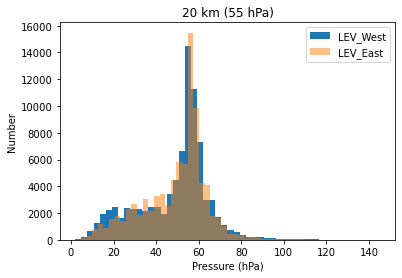

In [36]:
plt.hist(LEV1_exit_W, bins=50, label="LEV_West")
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Number");

plt.hist(LEV1_exit_E, bins=50, label="LEV_East", alpha=0.5)
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Number");

plt.legend()
print(len(LEV1_exit_W), len(LEV1_exit_E))

85680 85680


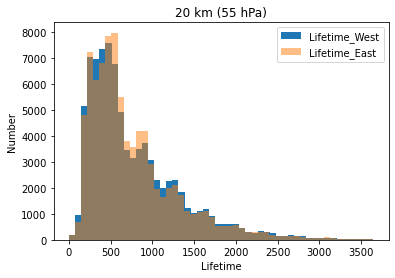

In [37]:
plt.hist(lifetime2_W, bins=50, label="Lifetime_West")
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.ylabel("Number");

plt.hist(lifetime2_E, bins=50, label="Lifetime_East", alpha=0.5)
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Lifetime")
plt.ylabel("Number");

plt.legend()
print(len(LEV1_exit_W), len(LEV1_exit_E))

85680 85680


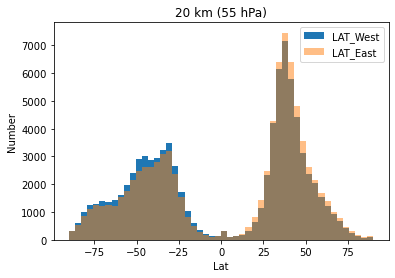

In [38]:
plt.hist(LAT2_sink_W, bins=50, label="LAT_West")
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.ylabel("Number");

plt.hist(LAT2_sink_E, bins=50, label="LAT_East", alpha=0.5)
plt.title(f"{Height[iz]:.0f} km ({Pressure[iz]} hPa)")
plt.xlabel("Lat")
plt.ylabel("Number");

plt.legend()
print(len(LEV1_exit_W), len(LEV1_exit_E))

In [39]:
# create seasonal data

N_season = 4

lifetime_season = np.zeros((Nz, Ny, Nx, N_season, N_year))
lifetime_N_season = np.zeros((Nz, Ny, Nx, N_season, N_year))
lifetime_S_season = np.zeros((Nz, Ny, Nx, N_season, N_year))

# for Winter
lifetime_season[:,:,:,0,:] = np.mean(lifetime[:,:,:,:,[0,1,11],:], axis=(3,4))
lifetime_N_season[:,:,:,0,:] = np.mean(lifetime_N[:,:,:,:,[0,1,11],:], axis=(3,4))
lifetime_S_season[:,:,:,0,:] = np.mean(lifetime_S[:,:,:,:,[0,1,11],:], axis=(3,4))

# for Spring, Summer and Autumn
for i in range(1,N_season):
    print(i,i*3-1,(i+1)*3-1)
    lifetime_season[:,:,:,i,:]   = np.mean( lifetime[:,:,:,:,i*3-1:(i+1)*3-1,:], axis=(3,4))
    lifetime_N_season[:,:,:,i,:] = np.mean( lifetime_N[:,:,:,:,i*3-1:(i+1)*3-1,:], axis=(3,4))
    lifetime_S_season[:,:,:,i,:] = np.mean( lifetime_S[:,:,:,:,i*3-1:(i+1)*3-1,:], axis=(3,4))


lifetime_season_mean   = np.zeros((Nz, Ny, Nx, N_season))
lifetime_N_season_mean = np.zeros((Nz, Ny, Nx, N_season))
lifetime_S_season_mean = np.zeros((Nz, Ny, Nx, N_season))

for i in range(0,N_season):
    lifetime_season_mean[:,:,:,i] = np.mean(lifetime_season[:,:,:,i,:], axis=3)
    lifetime_N_season_mean[:,:,:,i] = np.mean(lifetime_N_season[:,:,:,i,:], axis=3)
    lifetime_S_season_mean[:,:,:,i] = np.mean(lifetime_S_season[:,:,:,i,:], axis=3)



NameError: name 'lifetime' is not defined